In [1]:
!pip install torch scikit-learn
import polars as pl
from pathlib import Path

# ==============================
# Config
# ==============================
DATA_DIR = Path("data/backblaze")
SINGLE_PARQUET = Path("hdd_full_clean.parquet")
PARTITION_DIR = Path("hdd_parquet_by_year")
PARTITION_DIR.mkdir(parents=True, exist_ok=True)

df = pl.read_parquet("hdd_full_clean.parquet")
print(df.shape)
print(df.columns[:20])  # peek at first 20 columns


(193599527, 11)
['date', 'serial_number', 'model', 'failure', 'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw', 'year']


In [2]:
df.head

<bound method DataFrame.head of shape: (193_599_527, 11)
┌────────────┬────────────┬────────────┬─────────┬───┬────────────┬────────────┬────────────┬──────┐
│ date       ┆ serial_num ┆ model      ┆ failure ┆ … ┆ smart_194_ ┆ smart_197_ ┆ smart_198_ ┆ year │
│ ---        ┆ ber        ┆ ---        ┆ ---     ┆   ┆ raw        ┆ raw        ┆ raw        ┆ ---  │
│ date       ┆ ---        ┆ str        ┆ i8      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ i32  │
│            ┆ str        ┆            ┆         ┆   ┆ i64        ┆ i64        ┆ i64        ┆      │
╞════════════╪════════════╪════════════╪═════════╪═══╪════════════╪════════════╪════════════╪══════╡
│ 2020-01-01 ┆ Z305B2QN   ┆ ST4000DM00 ┆ 0       ┆ … ┆ 22         ┆ 0          ┆ 0          ┆ 2020 │
│            ┆            ┆ 0          ┆         ┆   ┆            ┆            ┆            ┆      │
│ 2020-01-01 ┆ ZJV0XJQ4   ┆ ST12000NM0 ┆ 0       ┆ … ┆ 28         ┆ 0          ┆ 0          ┆ 2020 │
│            ┆            ┆ 007   

In [3]:
import polars as pl
import numpy as np
import pandas as pd  # only for final conversion

# df is Polars DataFrame from pl.read_parquet(...)
feature_cols = [c for c in df.columns if c.startswith("smart_")]
print("SMART features:", len(feature_cols))

# Failure dates (Polars)
failed_dates = (
    df.filter(pl.col("failure") == 1)
      .group_by("serial_number")                        # <-- use group_by in Polars >=1.0
      .agg(pl.col("date").max().alias("failure_date"))
)
fail_date_map = {r["serial_number"]: r["failure_date"] for r in failed_dates.iter_rows(named=True)}

failed_serials = list(fail_date_map.keys())

# Filter failed drives and convert to pandas only now
pdf = (
    df.filter(pl.col("serial_number").is_in(failed_serials))
      .with_columns(pl.col("date").cast(pl.Datetime))   # ensure datetime
      .sort(["serial_number","date"])
).to_pandas()

pdf["date"] = pd.to_datetime(pdf["date"])

# --- STEP 2: Build MANY windows per drive (sliding), not just the last one ---
K = 60          # sequence length (days)
MIN_SEQ = 10    # minimum days to keep a sequence
STEP = 7        # stride between windows (days)
RUL_CAP = 180   # cap very large RULs to 180 days (optional, helps stability)
USE_LOG_RUL = True  # train on log1p(RUL); invert at evaluation

sequences, targets, meta = [], [], []

for serial, g in pdf.groupby("serial_number", sort=False):
    g = g.sort_values("date")
    fdate = pd.to_datetime(fail_date_map[serial])
    g = g[g["date"] < fdate]
    if len(g) < MIN_SEQ:
        continue

    # sliding windows ending at indices [K, K+STEP, K+2*STEP, ...]
    for end_idx in range(K, len(g) + 1, STEP):
        window = g.iloc[end_idx - K:end_idx]
        if len(window) < K:
            continue

        X = window[feature_cols].astype(float).fillna(0.0).values
        last_t = window["date"].iloc[-1]
        rul_days = (fdate - last_t).days
        if rul_days <= 0:
            continue

        # optional cap
        if RUL_CAP is not None:
            rul_days = min(rul_days, RUL_CAP)

        sequences.append(X)
        targets.append(rul_days)
        meta.append((serial, last_t, window["model"].iloc[-1]))

X = np.stack(sequences)
y = np.array(targets, dtype=float)

# Optional: log-transform labels for training
if USE_LOG_RUL:
    y = np.log1p(y)

print("Dataset (windows, seq_len, features):", X.shape, "| targets shape:", y.shape)


SMART features: 6
Dataset (windows, seq_len, features): (417889, 60, 6) | targets shape: (417889,)


In [4]:
# === Self-healing: split+scale + balanced dataloaders + Transformer model ===
import math, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ---- 0) Preconditions ----
assert 'X' in globals() and 'y' in globals() and 'meta' in globals(), \
    "Missing X, y, or meta. Run the sequence-building cell first."

# ---- 1) Create splits if missing ----
if any(name not in globals() for name in ['X_train','X_val','X_test','y_train','y_val','y_test']):
    meta_df = pd.DataFrame(meta, columns=["serial","window_end","model"])
    unique_serials = meta_df["serial"].unique()
    train_s, test_s = train_test_split(unique_serials, test_size=0.2, random_state=42)
    train_s, val_s  = train_test_split(train_s, test_size=0.2, random_state=42)

    def mask_by_serial(slist):
        m = meta_df["serial"].isin(slist).values
        return X[m], y[m], meta_df[m]

    X_train, y_train, meta_train = mask_by_serial(train_s)
    X_val,   y_val,   meta_val   = mask_by_serial(val_s)
    X_test,  y_test,  meta_test  = mask_by_serial(test_s)

    print("Created splits:",
          "Train", X_train.shape, "| Val", X_val.shape, "| Test", X_test.shape)

# ---- 2) Balanced sampler weights (on training RULs in days) ----
def inv_transform(arr):
    return np.expm1(arr) if 'USE_LOG_RUL' in globals() and USE_LOG_RUL else arr

y_train_days = inv_transform(y_train)

bins = np.array([0, 7, 30, 90, 180, np.inf])
train_bin_id = np.digitize(y_train_days, bins, right=True)

bin_counts = np.bincount(train_bin_id, minlength=len(bins)+1)[:len(bins)+1]
bin_counts = np.where(bin_counts == 0, 1, bin_counts)

TEMP = 0.7  # smoothing, 1.0=no smoothing
counts_smooth = bin_counts.astype(float) ** TEMP
bin_weights = 1.0 / counts_smooth
bin_weights = bin_weights / bin_weights.sum()
bin_weights = np.maximum(bin_weights, 1e-6)
bin_weights = bin_weights / bin_weights.sum()

sample_weights = bin_weights[train_bin_id].astype(np.float32)

print("Bin counts:", dict(enumerate(bin_counts)))
print("Bin weights:", dict(enumerate(np.round(bin_weights,6))))

# ---- 3) Scale features using train only (if not yet scaled) ----
if '_scaled' not in globals():
    scaler = StandardScaler()
    n_feat = X.shape[-1]
    scaler.fit(X_train.reshape(-1, n_feat))

    def apply_scale(arr):
        return scaler.transform(arr.reshape(-1, n_feat)).reshape(arr.shape)

    X_train = apply_scale(X_train)
    X_val   = apply_scale(X_val)
    X_test  = apply_scale(X_test)
    _scaled = True
    print("Scaled features with StandardScaler (fit on train).")

# ---- 4) Dataset + Dataloaders ----
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

batch_size = 64
sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.float32),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(SeqDataset(X_train, y_train), batch_size=batch_size, sampler=sampler)
val_loader   = DataLoader(SeqDataset(X_val,   y_val),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(SeqDataset(X_test,  y_test),  batch_size=batch_size, shuffle=False)

# ---- 5) Transformer model ----
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x):  # x: (B,T,D)
        T = x.size(1)
        return x + self.pe[:, :T, :]

class RULTransformer(nn.Module):
    def __init__(self, in_dim, d_model=128, nhead=4, num_layers=2, dim_ff=256, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, d_model)
        self.pos = PositionalEncoding(d_model)
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                         dim_feedforward=dim_ff, dropout=dropout,
                                         batch_first=True)
        self.encoder = nn.TransformerEncoder(enc, num_layers=num_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )
    def forward(self, x):   # x: (B,T,F)
        z = self.input_proj(x)
        z = self.pos(z)
        z = self.encoder(z)
        return self.head(z[:, -1, :]).squeeze(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RULTransformer(in_dim=X_train.shape[-1]).to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

print("Ready. Device:", device, "| Features:", X_train.shape[-1], "| Seq len:", X_train.shape[1])


Created splits: Train (267811, 60, 6) | Val (66845, 60, 6) | Test (83233, 60, 6)
Bin counts: {0: np.int64(1), 1: np.int64(3585), 2: np.int64(11540), 3: np.int64(28731), 4: np.int64(39889), 5: np.int64(184066), 6: np.int64(1)}
Bin weights: {0: np.float64(0.498443), 1: np.float64(0.00162), 2: np.float64(0.000715), 3: np.float64(0.000377), 4: np.float64(0.0003), 5: np.float64(0.000103), 6: np.float64(0.498443)}
Scaled features with StandardScaler (fit on train).
Ready. Device: cpu | Features: 6 | Seq len: 60


Epoch 01 | train MAE 0.853 | val MAE 0.401
Epoch 02 | train MAE 0.831 | val MAE 0.388
Epoch 03 | train MAE 0.810 | val MAE 0.461
Epoch 04 | train MAE 0.803 | val MAE 0.361
Epoch 05 | train MAE 0.799 | val MAE 0.357
Epoch 06 | train MAE 0.801 | val MAE 0.328
Epoch 07 | train MAE 0.799 | val MAE 0.370
Epoch 08 | train MAE 0.795 | val MAE 0.464
Epoch 09 | train MAE 0.796 | val MAE 0.364
Epoch 10 | train MAE 0.821 | val MAE 0.392
Epoch 11 | train MAE 0.820 | val MAE 0.357
Early stopping.


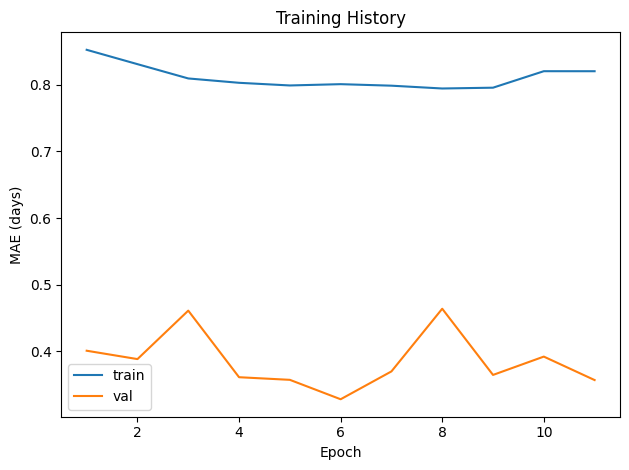

In [5]:
# === Step 3: Train with early stopping + save best + plot history (fixed) ===
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define/export directory (only if missing)
if 'EXPORT_DIR' not in globals():
    EXPORT_DIR = Path("exports_rul")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

best_val = float("inf")
patience = 5
pat = 0
history = []

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total, n = 0.0, 0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            if train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            total += loss.item() * len(xb)
            n += len(xb)
    return total / max(1, n)

max_epochs = 50
for ep in range(1, max_epochs + 1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader, False)
    history.append((ep, tr, va))
    print(f"Epoch {ep:02d} | train MAE {tr:.3f} | val MAE {va:.3f}")
    if va < best_val - 1e-4:
        best_val = va
        pat = 0
        torch.save(model.state_dict(), EXPORT_DIR / "rul_transformer.pt")
    else:
        pat += 1
        if pat >= patience:
            print("Early stopping.")
            break

# Plot history (and save)
plt.figure()
plt.plot([h[0] for h in history], [h[1] for h in history], label="train")
plt.plot([h[0] for h in history], [h[2] for h in history], label="val")
plt.xlabel("Epoch"); plt.ylabel("MAE (days)"); plt.title("Training History")
plt.legend(); plt.tight_layout()
plt.savefig(EXPORT_DIR / "training_history.png", dpi=150)
plt.show()


Test MAE: 0.32 days | Test MAPE: 10.11%


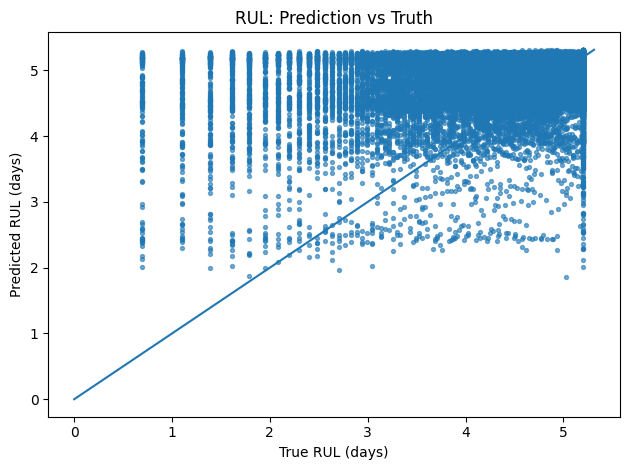

In [6]:
# --- Evaluate ---
model.load_state_dict(torch.load(EXPORT_DIR / "rul_transformer.pt", map_location=device))
model.eval()

yt, yp = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb.to(device)).cpu().numpy()
        yt.append(yb.numpy()); yp.append(pred)
yt = np.concatenate(yt); yp = np.concatenate(yp)

mae = np.mean(np.abs(yt - yp))
mape = np.mean(np.abs((yt - yp) / np.maximum(1.0, yt)))
print(f"Test MAE: {mae:.2f} days | Test MAPE: {mape*100:.2f}%")

# Scatter: predicted vs true
plt.figure()
plt.scatter(yt, yp, s=8, alpha=0.6)
m = float(max(np.max(yt), np.max(yp)))
plt.plot([0, m], [0, m])
plt.xlabel("True RUL (days)"); plt.ylabel("Predicted RUL (days)")
plt.title("RUL: Prediction vs Truth")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "rul_scatter.png", dpi=150)
plt.show()

# Save preds/metrics
pd.DataFrame({"true": yt, "pred": yp}).to_parquet(EXPORT_DIR / "rul_test_preds.parquet", index=False)
with open(EXPORT_DIR / "metrics.txt", "w") as f:
    f.write(f"Test MAE: {mae:.4f}\nTest MAPE: {mape:.6f}\n")


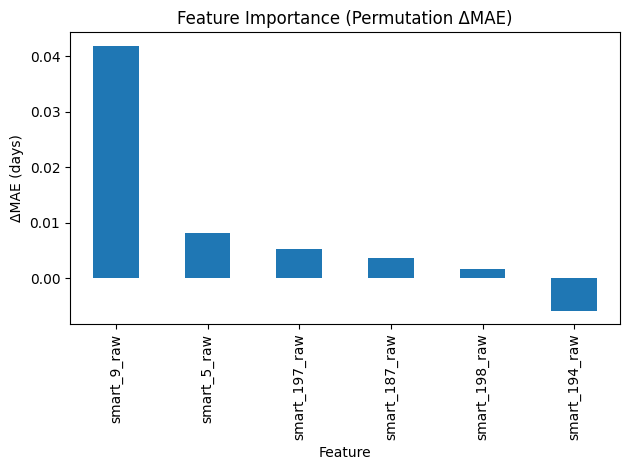

In [7]:
# --- Permutation-style feature importance (ΔMAE when a feature is zeroed) ---
feat_names = feature_cols  # from earlier

def permutation_importance(model, X_base, y_base, max_samples=512):
    n = min(max_samples, len(y_base))
    Xb = X_base[:n].copy()
    yb = y_base[:n].copy()

    model.eval()
    with torch.no_grad():
        base = model(torch.tensor(Xb, dtype=torch.float32, device=device)).cpu().numpy()
    base_mae = np.mean(np.abs(base - yb))

    imp = np.zeros(Xb.shape[-1], dtype=float)
    for j in range(Xb.shape[-1]):
        Xmask = Xb.copy()
        Xmask[..., j] = 0.0
        with torch.no_grad():
            pred = model(torch.tensor(Xmask, dtype=torch.float32, device=device)).cpu().numpy()
        mae = np.mean(np.abs(pred - yb))
        imp[j] = mae - base_mae
    return imp

imp = permutation_importance(model, X_test, y_test)
fi_perm = pd.Series(imp, index=feat_names).sort_values(ascending=False)

topk = min(20, len(fi_perm))
plt.figure()
fi_perm.head(topk).plot(kind="bar")
plt.title("Feature Importance (Permutation ΔMAE)")
plt.ylabel("ΔMAE (days)"); plt.xlabel("Feature")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "feature_importance_permutation_top20.png", dpi=150)
plt.show()

fi_perm.to_csv(EXPORT_DIR / "feature_importance_permutation.csv")


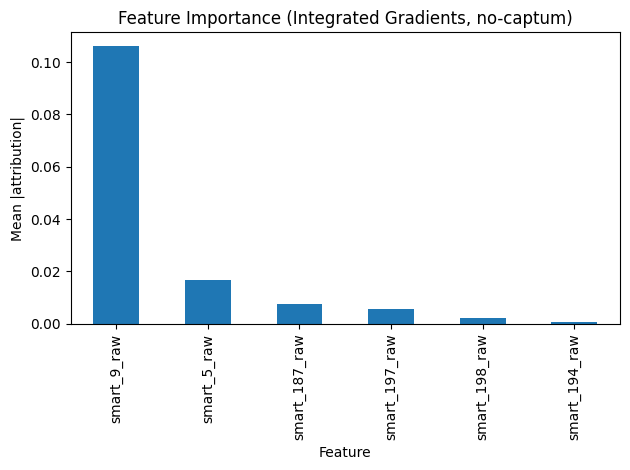

In [8]:
# === Step 6 (no captum): Integrated Gradients + Grad×Input, pure PyTorch ===
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure EXPORT_DIR exists
if 'EXPORT_DIR' not in globals():
    EXPORT_DIR = Path("exports_rul")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

def integrated_gradients(model, inputs, baseline=None, steps=50):
    """
    inputs: torch.FloatTensor (B, T, F) on device
    baseline: same shape (defaults to zeros)
    steps: number of Riemann steps
    returns: attributions with same shape as inputs
    """
    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    # Generate scaled inputs
    alphas = torch.linspace(0.0, 1.0, steps, device=inputs.device).view(-1, 1, 1, 1)  # (S,1,1,1)
    expanded_inputs = baseline.unsqueeze(0) + alphas * (inputs.unsqueeze(0) - baseline.unsqueeze(0))  # (S,B,T,F)

    # Compute gradients at each alpha
    grads = []
    for s in range(steps):
        x = expanded_inputs[s]
        x.requires_grad_(True)
        out = model(x)                            # (B,)
        # sum over batch so backward creates grads for all samples
        out.sum().backward()
        grads.append(x.grad.detach())             # (B,T,F)
        x.requires_grad_(False)

    grads = torch.stack(grads, dim=0)            # (S,B,T,F)
    avg_grads = grads.mean(dim=0)                # (B,T,F)

    # Path-integral * (inputs - baseline)
    attributions = (inputs - baseline) * avg_grads
    return attributions

def grad_times_input(model, inputs):
    """Simple saliency: ∂y/∂x * x."""
    model.eval()
    x = inputs.clone().detach().requires_grad_(True)
    y = model(x).sum()
    y.backward()
    return x.grad * x

# ---- Compute attributions on a subset of the test set ----
# Build a small batch tensor on the correct device
n_ig = min(64, len(X_test))
Xb = torch.tensor(X_test[:n_ig], dtype=torch.float32, device=device)

# Integrated Gradients
atts_ig = integrated_gradients(model, Xb, baseline=None, steps=50).detach().cpu().numpy()  # (B,T,F)

# Grad×Input (optional sanity check)
atts_gxi = grad_times_input(model, Xb).detach().cpu().numpy()  # (B,T,F)

# Aggregate to feature importances: average absolute attribution over batch and time
feat_attr_ig  = np.mean(np.abs(atts_ig), axis=(0, 1))   # (F,)
feat_attr_gxi = np.mean(np.abs(atts_gxi), axis=(0, 1))  # (F,)

# Use your original feature list (SMART columns)
feat_names = feature_cols

# Save and plot Integrated Gradients top-20
fi_ig = pd.Series(feat_attr_ig, index=feat_names).sort_values(ascending=False)
fi_ig.to_csv(EXPORT_DIR / "feature_importance_integrated_gradients.csv")

topk = min(20, len(fi_ig))
plt.figure()
fi_ig.head(topk).plot(kind="bar")
plt.title("Feature Importance (Integrated Gradients, no-captum)")
plt.ylabel("Mean |attribution|")
plt.xlabel("Feature")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "feature_importance_ig_top20.png", dpi=150)
plt.show()

# (Optional) Save Grad×Input for comparison
fi_gxi = pd.Series(feat_attr_gxi, index=feat_names).sort_values(ascending=False)
fi_gxi.to_csv(EXPORT_DIR / "feature_importance_grad_times_input.csv")


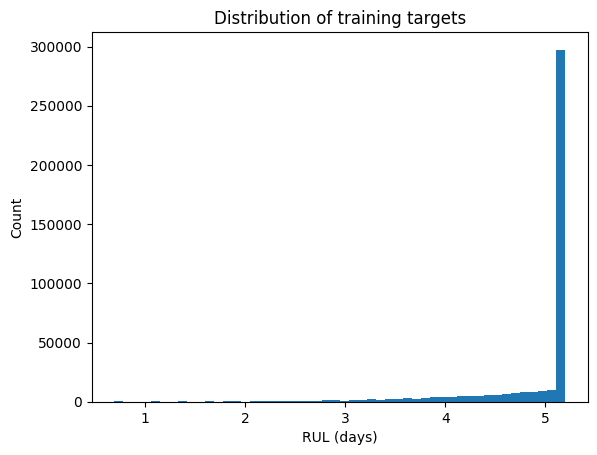

In [9]:
import matplotlib.pyplot as plt
plt.hist(y, bins=50)
plt.xlabel("RUL (days)")
plt.ylabel("Count")
plt.title("Distribution of training targets")
plt.show()
